# **Intro**
In this notebook I set up semi-supervised VAE that disentangles the rotation and digits of MNIST numbers. 
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: rotation, digit, and everything else (slack).
To enforce this disentanglement, there are classification losses on the rotation and digit embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.

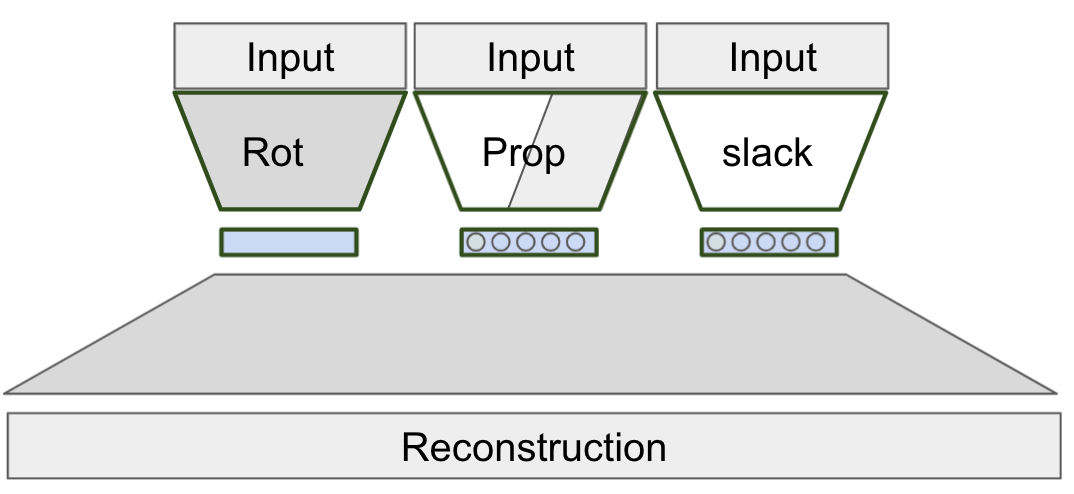


The experimental set-up is as follows:
The numbers are rotated 0, 15, 30, 45, 60, and 75 degrees. 
The model differentiates domains (rotations, referred to as *labels* in the code) from predicted values (digits, , referred to as *Y* in the code). 
The idea is to be able to provide correct labels in a new domain. 
The semi-supervision section has a new domain (30 degrees) without a Y (no digit).


This is analogous to the following situation: 
single-cell profiles where a patient or sequencing method is the domain (noise we would like to remove) and cell type (the label) is what we would like to predict.
This is done in a semi-supervised fashion because we would like to use bulk data in addition to single-cell.
However, bulk data is assumed to be a sum over many cell-types (i.e. we don't know the labels).
There is one simplification in this approach -- we predict a single-cell type for now.
Realistically, we predict a continuous vector of cell-type proportions.
Currently, we predict a 1-hot representation of cell-type identity.

Using both of these sources of data we hope that we can work on OOD stuff.
We focus on interpolation, not extrapolation, but this is not directly done in this notebook.

This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [77]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [78]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 12
-rw-r--r-- 1 root root  43 Sep  8 23:25 config
-rw------- 1 root root 432 Sep  8 23:25 id_rsa
-rw-r--r-- 1 root root 113 Sep  8 23:25 id_rsa.pub


In [79]:
%%bash
# do your git operations here

git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   experiments/rotated_example_ssDIVA_mnist.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	experiments/pbmc1a_ssDIVA.ipynb
	sc_preprocessing/

no changes added to commit (use "git add" and/or "git commit -a")


# **Imports**

In [80]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# load methods from other files
from mnist_preprocessing import generate_data as gd

# I disable eager execution ... forgot why
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Populating the interactive namespace from numpy and matplotlib


# **Load / Pre-process data**
Import + reshape the non-rotated MNIST data

In [81]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
Y_train = to_categorical(Y_train)

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

print(Y_train)

(60000, 28, 28)
(10000, 28, 28)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Import + reshape and rotate MNIST data.
In our single-cell analogy, rotation is a treatment and the number value is a cell-type.

In [82]:
(X_train_r, Y_train_r), (X_test_r, Y_test_r) = mnist.load_data()
Y_train_r = to_categorical(Y_train_r)
# now add in the rotation
def rotate_90(img):
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

def rotate_deg(in_img, angle):
  img = Image.fromarray(np.uint8(in_img) , 'L')
  img = img.rotate(angle)
  return np.asarray(img)

def rotate_data(X_train, Y_train, X_test, Y_test, angle):
  # rotate the training data
  X_train_15 = np.array([rotate_deg(xi, angle) for xi in X_train_r])
  Y_train_15 = Y_train

  # rotate the test data
  X_test_15 = np.array([rotate_90(xi) for xi in X_test_r])
  Y_test_15 = Y_test

  # reshape the data
  X_train_15 = X_train_15.astype('float32') / 255.
  X_test_15 = X_test_15.astype('float32') / 255.

  n_pixels = np.prod(X_train_15.shape[1:])
  X_train_15 = X_train_15.reshape((len(X_train_15), n_pixels))
  X_test_15 = X_test_15.reshape((len(X_test_15), n_pixels))

  return (X_train_15, Y_train_15, X_test_15, Y_test_15)

X_train_15, Y_train_15, X_test_15, Y_test_15 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 15)
X_train_30, Y_train_30, X_test_30, Y_test_30 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 30)
X_train_45, Y_train_45, X_test_45, Y_test_45 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 45)
X_train_60, Y_train_60, X_test_60, Y_test_60 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 60)
X_train_75, Y_train_75, X_test_75, Y_test_75 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 75)



Demo the data, to make sure everything works

rotated 15


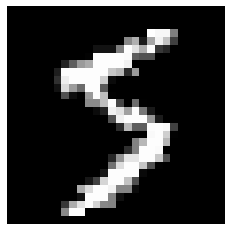

rotated 30


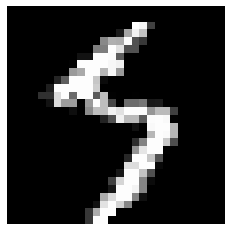

rotated 45


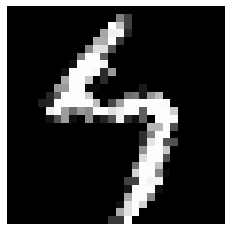

rotated 60


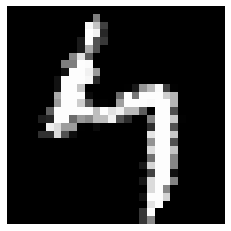

rotated 75


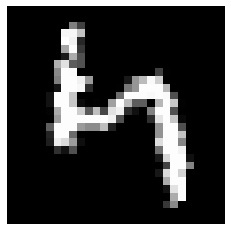

In [83]:
print("rotated 15")
plt.imshow(X_train_15[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 30")
plt.imshow(X_train_30[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 45")
plt.imshow(X_train_45[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 60")
plt.imshow(X_train_60[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 75")
plt.imshow(X_train_75[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# **Model Definition**


## Hyperparameters

In [84]:

batch_size = 500
n_epoch = 75

alpha_rot = 1000000
alpha_prop = 100 

beta_kl_slack = 10
beta_kl_rot = 100
beta_kl_prop = 10

# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

n_x = X_train.shape[1]
n_y = Y_train.shape[1]
n_label = 6  # 6 rotation angles
n_label_z = 64  # 64 dimensional representation of rotation

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")



length of X 784 and length of y 10 and n_label 6


## Encoder

In [85]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))

# concatenate input with the label 
inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_p = Dense(encoder_dim, activation=activ, name="encoder_prop")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_prop = Dense(n_z, activation='linear', name = "mu_prop")(encoder_p)
l_sigma_prop = Dense(n_z, activation='linear', name = "sigma_prop")(encoder_p)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


## Latent Space

In [86]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_z])
z_prop = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_prop")([mu_prop, l_sigma_prop, n_z])
z_rot = Lambda(sample_z, output_shape = (n_label, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])

z_concat = concat([z_slack, z_prop, z_rot])

## Decoder + Classifiers

In [87]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

d_in = Input(shape=(n_z+n_z+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# set up the decoder part that links to the encoder
h_p = decoder_hidden(z_concat)
outputs = decoder_out(h_p)

###### Proportions classifier
# this is the proportions we try to estimate
decoder_props = Softmax(name = "mu_prop_pred")

# we use this to get sigma to do sampling later
decoder_sigma = Lambda(null_f, name = "l_sigma_prop_pred")

prop_outputs = decoder_props(mu_prop)
sigma_outputs_p = decoder_sigma(l_sigma_prop)


###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_props = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_props(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)








## Loss

In [88]:

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl_prop = beta_kl_prop * K.sum(K.exp(l_sigma_prop) + K.square(mu_prop) - 1. - l_sigma_prop, axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_prop + kl_rot + kl_slack

def KL_loss(y_true, y_pred):
	return(beta_kl * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1) * alpha_prop


def prop_loss_unknown_iterate(y_true, y_pred):
  total_loss = 0
  for idx in range(0, 10):
    y_shuffle = np.zeros((500, 10))
    y_shuffle[:,idx] = 1
    y_temp = tf.convert_to_tensor(y_shuffle, dtype=tf.float32)
    total_loss = total_loss + K.sum(K.binary_crossentropy(y_temp, y_pred), axis=-1)
  return total_loss * alpha_prop

def prop_loss_unknown(y_true, y_pred):
  return K.sum(K.binary_crossentropy(prop_outputs, y_pred), axis=-1) * alpha_prop


def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [89]:

known_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs, sigma_outputs_p])
unknown_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, None]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss_unknown, class_loss]) #, metrics = [KL_loss, recon_loss])


encoder = Model(X, [z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot])

decoder = Model(d_in, d_out)

print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_slack (Dense)           (None, 512)          401920      input_9[0][0]                    
__________________________________________________________________________________________________
encoder_prop (Dense)            (None, 512)          401920      input_9[0][0]                    
__________________________________________________________________________________________________
encoder_rot (Dense)             (None, 512)          401920      input_9[0][0]                    
____________________________________________________________________________________________

# **Experimental Setup**

Now lets train and evaluate the model.
First we train with only some proportions of rotated 3's..
We will then decrease the proportion of rotated 3's in samples from 0.5 to 0.

In [90]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))


Setup the data so that we remove all the examples with a high proportion of rotated 3's

(360000, 784)
rotated 30


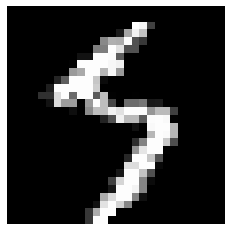

rotated 75


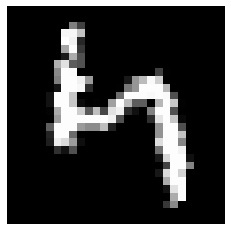

In [91]:
##################################################
#####. Design the experiment
##################################################

## 30 is unlabeled
## we test on 75

X_full = np.concatenate([X_train, X_train_15, X_train_30, X_train_45, X_train_60, X_train_75])
Y_full = np.concatenate([Y_train, Y_train_15, Y_train_30, Y_train_45, Y_train_60, Y_train_75])

print(X_full.shape)

### also create the condition label (degrees = label; 0=0, 15=1, 30=2, ... 75=5) 
n_train = Y_train.shape[0]
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                              np.full(n_train, 2), np.full(n_train, 3),
                              np.full(n_train, 4), np.full(n_train, 5)], axis=0)
label_full = to_categorical(Label_full)

# indexes for the training, 30 and 75
idx_train = np.where(np.logical_and(Label_full!=2, Label_full!=5))[0]
idx_30 = np.where(Label_full==2)[0]
idx_75 = np.where(Label_full==5)[0]

print("rotated 30")
plt.imshow(X_full[idx_30[0],].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 75")
plt.imshow(X_full[idx_75[0]].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()


# for unknown proportions; i.e. 30 degrees
X_unkp = X_full[idx_30,]
label_unkp = label_full[idx_30,]
y_unkp = Y_full[idx_30,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
y_kp = Y_full[idx_train,]


# test; i.e. 75 degrees
X_75 = X_full[idx_75,]
label_75 = label_full[idx_75,]
y_75 = Y_full[idx_75,]



# now take a subsample of the full dataset
unkp_size = 50000
kp_size = 50000
unkp_rand_idx = np.random.choice(X_unkp.shape[0], size=unkp_size, replace=False)
kp_rand_idx = np.random.choice(X_kp.shape[0], size=kp_size, replace=False)



# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [92]:
from tqdm import tnrange, tqdm_notebook


def fit_model(X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, epochs):
    assert len(X_known_prop) % len(X_unknown_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        labeled_index = np.arange(len(X_known_prop))
        np.random.shuffle(labeled_index)

        # Repeat the unlabeled data to match length of labeled data
        unlabeled_index = []
        for i in range(len(X_known_prop) // len(X_unknown_prop)):
            l = np.arange(len(X_unknown_prop))
            np.random.shuffle(l)
            unlabeled_index.append(l)
        unlabeled_index = np.concatenate(unlabeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = known_prop_vae.train_on_batch(X_known_prop[index_range], 
                                                      [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range]])
                
                # Unlabeled
                y_shuffle = np.identity(10, dtype=np.float32)
                for idx in range(0, 49):
                  y_shuffle = np.vstack((y_shuffle, np.identity(10, dtype=np.float32)))
                #np.random.shuffle(y_shuffle)
                y_shuffle = np.zeros((batch_size, 10))
                y_shuffle[:,0] = 1
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range], 
                                                         [X_unknown_prop[index_range], y_shuffle, label_unknown_prop[index_range]])]


                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

Now train

In [93]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
history = fit_model(X_unkp[unkp_rand_idx,:],
                    label_unkp[unkp_rand_idx,:],
                    X_kp[kp_rand_idx,:], 
                    y_kp[kp_rand_idx,:],
                    label_kp[kp_rand_idx,:], epochs=n_epoch)

print(X_75[0].shape) 
print(y_75[0].shape)


z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_75, batch_size=batch_size)
test_error = [mean_abs_error(mu_prop[idx], y_75[idx]) 
                  for idx in range(0, X_75.shape[1])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")




  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Elapsed:  1683.2261455059052
(784,)
(10,)
mean test_error: 0.42800000309944153
median test_error: 0.4230000078678131
max test_error: 0.8809999823570251


# **Inspect the output**

We will take two examples from our training and see how well it reconstructs.
We first look at the ground truth so we know what we should expect.

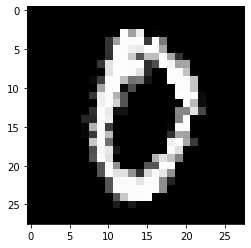

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0.]


In [94]:
plot_idx = 1

plt.imshow(X_unkp[plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(y_unkp[plot_idx])
print(label_unkp[plot_idx])


## TSNE unseen data (75 degrees)

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.703s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.396443
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.195267
[t-SNE] KL divergence after 300 iterations: 1.810546
t-SNE done! Time elapsed: 14.64479374885559 seconds
(5000, 2)
(5000, 2)


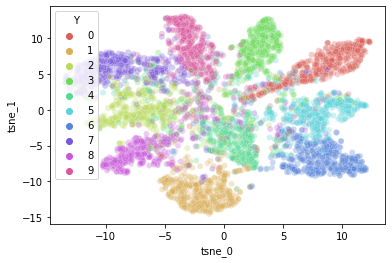

In [95]:
# plot proportions on unseen DATA
X_temp = X_full[idx_75,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_75,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)



## TSNE unlabeled data  (30 degrees)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.176672
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.325363
[t-SNE] KL divergence after 300 iterations: 1.720466
t-SNE done! Time elapsed: 14.993887186050415 seconds
(5000, 2)
(5000, 2)


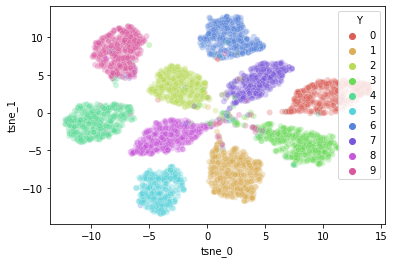

In [96]:
# plot proportions on unlabeled DATA
X_temp = X_full[idx_30,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_75,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)



## TSNE All data (0-75)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.271908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.421242
[t-SNE] KL divergence after 300 iterations: 1.603752
t-SNE done! Time elapsed: 14.20369839668274 seconds
(5000, 2)
(5000, 2)


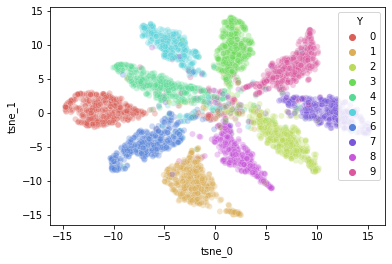

In [97]:
# plot proportions on ALL DATA
X_temp = X_full

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)



(5000, 2)
(5000, 2)


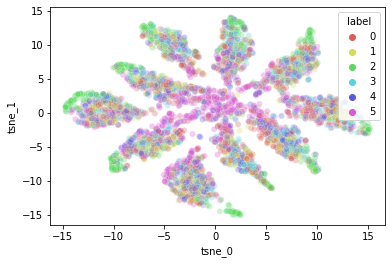

In [98]:
# plot rotations on digit embedding
# to see if rotation+digit are entangled
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 6),
    legend="full",
    alpha=0.3
)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.039s...
[t-SNE] Computed neighbors for 5000 samples in 4.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.231709
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.701141
[t-SNE] KL divergence after 300 iterations: 2.621229
t-SNE done! Time elapsed: 29.600762367248535 seconds
(5000, 2)
(5000, 2)


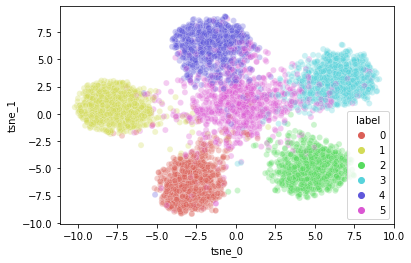

In [99]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 6),
    legend="full",
    alpha=0.3
)

(5000, 2)
(5000, 2)


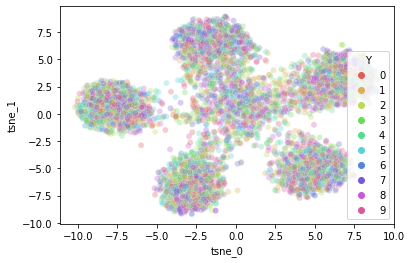

In [100]:
# plot digits on rotation embedding
# to see if rotation+digit are entangled

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

## TSNE Training data

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.734s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.236498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.169846
[t-SNE] KL divergence after 300 iterations: 1.723773
t-SNE done! Time elapsed: 14.60166621208191 seconds
(5000, 2)
(5000, 2)


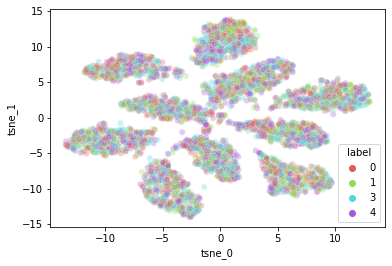

In [101]:
# plot proportion latent space of training data
X_temp = X_full[idx_train,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)




(5000, 2)
(5000, 2)


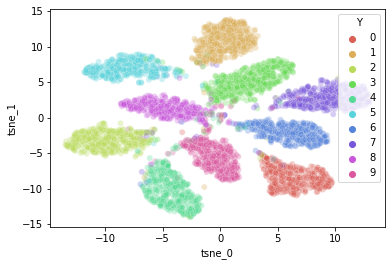

In [102]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)





[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.037s...
[t-SNE] Computed neighbors for 5000 samples in 4.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.160413
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.699722
[t-SNE] KL divergence after 300 iterations: 2.750073
t-SNE done! Time elapsed: 24.050671815872192 seconds
(5000, 2)
(5000, 2)


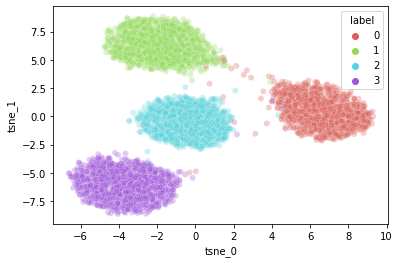

In [103]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)


(5000, 2)
(5000, 2)


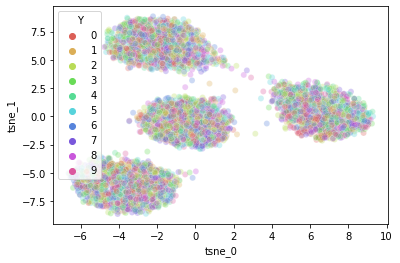

In [104]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.957s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.926845
[t-SNE] KL divergence after 50 iterations with early exaggeration: 85.118393
[t-SNE] KL divergence after 300 iterations: 3.128518
t-SNE done! Time elapsed: 15.92327356338501 seconds
(5000, 2)
(5000, 2)


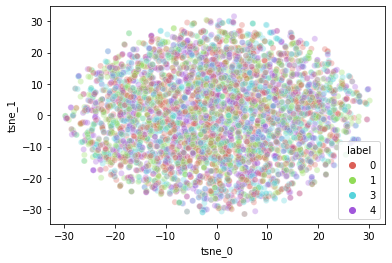

In [105]:
# plot remaining variance
z_test = z_slack
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)


(5000, 2)
(5000, 2)


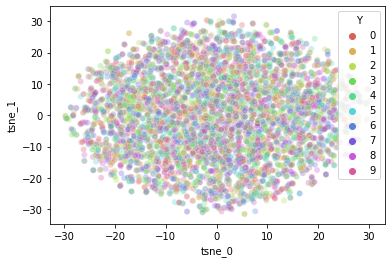

In [106]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)


# **Generate Data**

Here we will sample from each latent space and reconstruct a rotated digit.

rotated 3


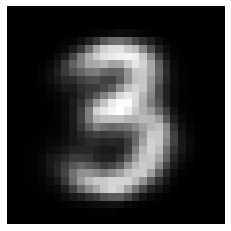

rotated 3


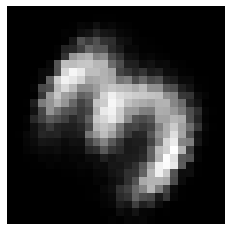

In [107]:

def method_sample_z(args):
    mu, l_sigma, n_dim = args
    eps = np.random.normal(size=(batch_size*5, n_dim), loc=0., scale=1.)
    return mu + np.exp(l_sigma / 2) * eps

def sample_digit(digit_img, X_temp, Y_temp):
  digit_idx = np.where(Y_temp == digit_img)

  pred_input = X_temp[digit_idx[0],]
  rand_idx = np.random.choice(pred_input.shape[0], size=batch_size*5, replace=False)
  pred_input = pred_input[rand_idx]

  z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(pred_input, batch_size=batch_size)

  z_0_digit = method_sample_z([mu_prop, l_sigma_prop, n_z])
  z_0_digit = np.median(z_0_digit, axis=0)
  z_0_digit = z_0_digit.reshape((1,n_z))
  return(z_0_digit)

def sample_rotation(rot_idx, X_temp, Label_temp):
  rot_idx = np.where(Label_temp == rot_idx)

  pred_input = X_temp[rot_idx[0]]
  rand_idx = np.random.choice(pred_input.shape[0], size=batch_size*5, replace=False)
  pred_input = pred_input[rand_idx]

  z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(pred_input, batch_size=batch_size)

  z_0_digit = method_sample_z([mu_rot, l_sigma_rot, n_label_z])
  z_0_digit = np.median(z_0_digit, axis=0)
  z_0_digit = z_0_digit.reshape((1,n_label_z))
  return(z_0_digit)

def sample_slack(X_temp):

  pred_input = X_temp
  rand_idx = np.random.choice(pred_input.shape[0], size=batch_size*5, replace=False)
  pred_input = pred_input[rand_idx]

  z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(pred_input, batch_size=batch_size)

  z_0_digit = method_sample_z([mu_slack, l_sigma_slack, n_z])
  z_0_digit = np.median(z_0_digit, axis=0)
  z_0_digit = z_0_digit.reshape((1,n_z))
  return(z_0_digit)

# try it out
digit_img = 3
rot_idx = 0 # 0 degrees

Y_temp = Y_full[idx_train,]
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_full[idx_train,]
Label_temp = Label_full[idx_train,]

# sample slack, prop, rot
slack_sample = sample_slack(X_temp)
z_0_digit = sample_digit(digit_img, X_temp, Y_temp)
rotate_1hot = sample_rotation(rot_idx, X_temp, Label_temp)

# put it together
pred_input = np.concatenate([slack_sample[0], z_0_digit[0], rotate_1hot[0]]).reshape((1,n_label_z+n_z+n_z))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

# it is rotated
rot_idx = 4 # 60 degrees
rotate_1hot = sample_rotation(rot_idx, X_temp, Label_temp)
pred_input = np.concatenate([slack_sample[0], z_0_digit[0], rotate_1hot[0]]).reshape((1,n_label_z+n_z+n_z))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

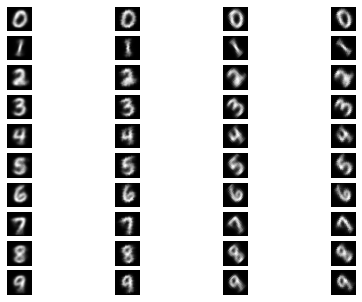

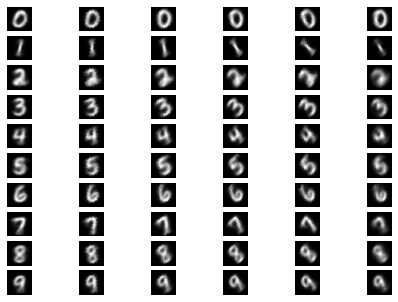

In [108]:
# plot reconstruction of training data
img_it = 0
sides = 10

Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_full[idx_train,]

Label_temp = Label_full[idx_train,]

for i in range(0, sides):
    for j in np.unique(Label_temp):
        
        # slack, prop, rot
        slack_sample = sample_slack(X_temp)
        z_0_digit = sample_digit(i, X_temp, Y_temp)
        rotate_1hot = sample_rotation(j, X_temp, Label_temp)

        # put it together
        pred_input = np.concatenate([slack_sample[0], z_0_digit[0], rotate_1hot[0]]).reshape((1,n_label_z+n_z+n_z))

        decoded = decoder.predict(pred_input)
        subplot(sides, 4, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()


# plot reconstruction of all data
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_full

Label_temp = Label_full
img_it = 0
for i in range(0, sides):
    for j in range(0, 6):
        
        # slack, prop, rot
        slack_sample = sample_slack(X_temp)
        z_0_digit = sample_digit(i, X_temp, Y_temp)
        rotate_1hot = sample_rotation(j, X_temp, Label_temp)

        # put it together
        pred_input = np.concatenate([slack_sample[0], z_0_digit[0], rotate_1hot[0]]).reshape((1,n_label_z+n_z+n_z))

        decoded = decoder.predict(pred_input)
        subplot(sides, 6, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()




## Walk across latent space

Interpolate each number, walking from 0 to 75 degrees in the latent space.

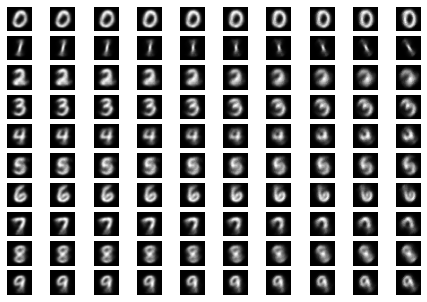

In [109]:
def walk_rotation(rot_start, rot_end, num_steps, X_temp, Label_temp):

  z_rot_start = sample_rotation(rot_start, X_temp, Label_temp)
  z_rot_end = sample_rotation(rot_end, X_temp, Label_temp)

  steps = linspace(0, 1, num=num_steps)
  # linear interpolate vectors
  vectors = list()
  for step in steps:
    v = (1.0 - step) * z_rot_start + step * z_rot_end
    vectors.append(v)
  return asarray(vectors)


img_it = 0
sides = 10
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
X_temp = X_full
Label_temp = Label_full
num_steps = 10
for i in range(0, sides):
        
    # slack, prop, rot
    slack_sample = sample_slack(X_temp)
    z_0_digit = sample_digit(i, X_temp, Y_temp)
    rotate_1hot = walk_rotation(0, 5, num_steps, X_temp, Label_temp)

    # plot each step
    for j in range(0, num_steps):

      curr_rotate = rotate_1hot[j,]

      # put it together
      pred_input = np.concatenate([slack_sample[0], z_0_digit[0], curr_rotate[0]]).reshape((1,n_label_z+n_z+n_z))

      decoded = decoder.predict(pred_input)
      subplot(sides, num_steps, 1 + img_it)
      img_it +=1
      plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()



# **Predict**

## Predict on reconstruction

Now we train a classification model on 75 degree rotated digits and test it on our reconstructed 75 degree rotated digits.

In [39]:
# train model to classify rotated numbers

# X_train_75, Y_train_75, X_test_75, Y_test_75

Y_argmax_75 = np.argmax(Y_train_75, axis=1)

#choosing the sequential model
classification_model = Sequential()

#defining the architecture of the model
X_class = Input(shape=(n_x))
classification_model.add(X_class)
classification_model.add(Dense(512, activation='relu'))
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
classification_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#training the model
classification_model.fit(X_train_75,Y_argmax_75,epochs=5, batch_size=batch_size)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3776 - accuracy: 0.8967
Epoch 2/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1321 - accuracy: 0.9615
Epoch 3/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0886 - accuracy: 0.9740
Epoch 4/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0606 - accuracy: 0.9821
Epoch 5/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0476 - accuracy: 0.9861


In [43]:
# test model to on our reconstructed test data
Y_temp = Y_full[idx_train]
Y_argmax = np.argmax(Y_temp, axis=1)

X_temp = X_full[idx_train,]

Label_temp = Label_full[idx_train,]

num_correct = 0
num_digits = 10
num_rep = 100
acc = []
for digit_idx in range(0, num_digits):
  num_correct = 0
  for idx_rep in range(0, num_rep):
    
    # slack, prop, rot
    slack_sample = sample_slack(X_temp)
    z_0_digit = sample_digit(digit_idx, X_temp, Y_temp)
    rotate_1hot = sample_rotation(5, X_temp, Label_temp)

    # put it together
    pred_input = np.concatenate([slack_sample[0], z_0_digit[0], rotate_1hot[0]]).reshape((1,n_label_z+n_z+n_z))

    decoded = decoder.predict(pred_input)

    predictions = classification_model.predict(decoded)

    if(digit_idx == np.argmax(predictions)):
      num_correct += 1
  acc = np.append(acc, num_correct)

print(np.mean(acc))
print(acc)

ValueError: ignored

In [59]:
# visualize the reconstructed rotated digit
digit_idx=5
for idx_rep in range(0, 10):
  # slack, prop, rot
  slack_sample = sample_slack(X_temp)
  z_0_digit = sample_digit(digit_idx, X_temp, Y_temp)
  rotate_1hot = sample_rotation(5, X_temp, Label_temp)

  # put it together
  pred_input = np.concatenate([slack_sample[0], z_0_digit[0], rotate_1hot[0]]).reshape((1,n_label_z+n_z+n_z))

  decoded = decoder.predict(pred_input)

  print(f"rotated {digit_idx}")
  plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
  plt.show()



ValueError: ignored

## Predict on Z_digit

In [76]:
# test model on our invariant z_digit
Y_temp = Y_full[idx_75]
Y_digit = np.argmax(Y_temp, axis=1)
X_temp = X_full[idx_75,]
Label_temp = Label_full[idx_75,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings = np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)


np.sum(Y_digit == np.argmax(encodings, axis=1))



49809